In [1]:
import os    
#os.environ['THEANO_FLAGS'] = "device=gpu1"  
#os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32,lib.cnmem=1"
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32"
import theano

from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import *
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold

from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc as misc
from scipy.ndimage import *
import random
from skimage import transform
%matplotlib inline

# this is the size of our encoded representations
#encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
#encoding_dim = 3
encoding_dim = 40


# this is our input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = Dense(676, activation='relu')(input_img) #26X26
encoded = Dense(484, activation='relu')(encoded) #22X22
encoded = Dense(324, activation='relu')(encoded)  #18X18
encoded = Dense(144, activation='relu')(encoded)  #12X12
encoded = Dense(64, activation='relu')(encoded)  #8X8

encoded = Dense(encoding_dim, activation='relu')(encoded)

# "decoded" is the lossy reconstruction of the input

decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)


Using gpu device 0: GeForce 920M (CNMeM is disabled, cuDNN not available)
Using Theano backend.


In [2]:
print (encoding_dim)
print (input_img)
print (encoded)
print (decoded)
print (autoencoder)

40
input_1
Elemwise{mul,no_inplace}.0
sigmoid.0


In [3]:
# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

In [4]:
print (encoder)

In [5]:
# create a placeholder for an encoded  input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

In [6]:
print (encoded_input)
print (decoder_layer)
print (decoder)

input_2


In [7]:
#autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy',metrics=['accuracy'])

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
print (y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [9]:
print(x_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)


In [10]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [11]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
print(len(x_train))
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)
print (x_train.dtype)
print (x_test.dtype)
print (x_train)
print (x_test)

60000
(60000, 784)
(10000, 784)
(60000,)
(10000,)
float32
float32
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [12]:
nfold=5
nb_epoch=50
batch_size=256
random_state =335

In [13]:
kfold_weights_path = os.path.join('mnist_weights_kfold_' + str(nfold) + 
                                  '_epoch_'+str(nb_epoch)+
                                  '_batch_'+str(batch_size) +
                                  '_encoded_'+str(encoding_dim) +
                                  '.h5')
print(kfold_weights_path)

mnist_weights_kfold_5_epoch_50_batch_256_encoded_40.h5


In [14]:
kf = KFold(len(x_train), n_folds=nfold, shuffle=True, random_state=random_state)
#kf = KFold(len(x_train), n_folds=nfold, shuffle=False, random_state=random_state)
#Shuffle false give very high training loss and very low val loss - indicating unknown fit

print(kf)

sklearn.cross_validation.KFold(n=60000, n_folds=5, shuffle=True, random_state=335)


In [15]:
train_full_encoded_imgs = np.zeros(shape=[x_train.shape[0],encoding_dim])
print(train_full_encoded_imgs.shape)
print(x_test.shape)
test_full_encoded_imgs = np.zeros(shape=[x_test.shape[0],encoding_dim])
test_full_decoded_imgs = np.zeros(shape=[x_test.shape[0],x_test.shape[1]])
print(test_full_encoded_imgs.shape)
print(test_full_decoded_imgs.shape)

(60000, 40)
(10000, 784)
(10000, 40)
(10000, 784)


In [16]:
os.path.isfile(kfold_weights_path)

False

In [17]:
# Disable this for avoiding using pretrained weights
#if os.path.isfile(kfold_weights_path):
#autoencoder.load_weights(kfold_weights_path)

In [18]:
num_fold = 0
restore_from_last_checkpoint=0
for train_index,valid_index in kf:
    s_train,s_valid  = x_train[train_index], x_train[valid_index]
    
    noise_factor = 0.3
    s_train_noisy = s_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=s_train.shape) 
    s_valid_noisy = s_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=s_valid.shape) 

    s_train_noisy = np.clip(s_train_noisy, 0., 1.)
    s_valid_noisy = np.clip(s_valid_noisy, 0., 1.)
    #y_train, y_test = y[train_index], y[test_index]
    
    num_fold += 1
    print('\n\nStart KFold number {} from {}'.format(num_fold, nfold))
    print('Split train: ', len(s_train_noisy), len(s_train))
    print('Split valid: ', len(s_valid_noisy), len(s_valid))

    if not os.path.isfile(kfold_weights_path) or restore_from_last_checkpoint == 0:
        callbacks = [
                EarlyStopping(monitor='val_loss', patience=3, verbose=0),
                ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0),
        ]
        history = autoencoder.fit(s_train_noisy, s_train,
                nb_epoch=nb_epoch,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(s_valid_noisy, s_valid),
                callbacks=callbacks)
        
    # Store train predictions
    train_encoded_imgs = encoder.predict(x_train,batch_size=batch_size, verbose=1)
    train_full_encoded_imgs = np.add(train_full_encoded_imgs,train_encoded_imgs)

    
    # Store test predictions
    test_encoded_imgs = encoder.predict(x_test,batch_size=batch_size, verbose=1)
    #full_encoded_imgs = np.vstack([full_encoded_imgs,encoded_imgs])
    test_full_encoded_imgs = np.add(test_full_encoded_imgs,test_encoded_imgs)
    #full_encoded_imgs.append(encoded_imgs)
    #print(full_encoded_imgs.shape)
    
    test_decoded_imgs = decoder.predict(test_encoded_imgs,batch_size=batch_size, verbose=1)
    #full_decoded_imgs = np.vstack([full_decoded_imgs,decoded_imgs])
    test_full_decoded_imgs = np.add(test_full_decoded_imgs,test_decoded_imgs)



Start KFold number 1 from 5
Split train:  48000 48000
Split valid:  12000 12000
Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 6s - loss: 588.1534 - acc: 0.0040 - val_loss: 558.5061 - val_acc: 0.0027
Epoch 2/50
48000/48000 [==============================] - 5s - loss: 553.8632 - acc: 0.0012 - val_loss: 545.2752 - val_acc: 0.0011
Epoch 3/50
48000/48000 [==============================] - 5s - loss: 544.6733 - acc: 0.0012 - val_loss: 538.9892 - val_acc: 0.0015
Epoch 4/50
48000/48000 [==============================] - 5s - loss: 539.2366 - acc: 0.0015 - val_loss: 535.0152 - val_acc: 0.0018
Epoch 5/50
48000/48000 [==============================] - 5s - loss: 536.5201 - acc: 0.0018 - val_loss: 532.7178 - val_acc: 0.0015
Epoch 6/50
48000/48000 [==============================] - 5s - loss: 534.1876 - acc: 0.0021 - val_loss: 531.1391 - val_acc: 0.0013
Epoch 7/50
48000/48000 [==============================] - 5s - loss: 532.4047 - ac

In [19]:
print(test_full_encoded_imgs.shape)
print(test_full_decoded_imgs.shape)
print(test_full_encoded_imgs)
print(test_full_decoded_imgs)

(10000, 40)
(10000, 784)
[[ 217.00048065  205.35572815  182.74699402 ...,  102.98294067
   391.65020752  366.79480743]
 [ 161.55693626  106.01868248  233.87490082 ...,  294.74440002
   183.18989563  178.14608002]
 [ 256.13962173  181.35288239  168.25052071 ...,   20.75791836
   424.25888062  294.49706268]
 ..., 
 [ 153.00442505   93.10964394   66.84814739 ...,  128.58690453
   279.96504974  247.64788818]
 [ 147.83215141  131.06148911  181.90516853 ...,  311.47685242
    61.30270481  299.39310837]
 [ 196.05006027  154.07032776  301.75289536 ...,  309.36872864  110.9663868
   287.96145248]]
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  3.88856110e-35   6.97208080e-31   6.55670978e-32 ...,   5.60257327e-35
    7.24045451e-32   1.19577784e-31]
 [  3.56577030e-37   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  1.03166307e-21   8.86094088e-23   1.38970123e-30 ...,   1

In [20]:
test_res_encoded_imgs = test_full_encoded_imgs/nfold
test_res_decoded_imgs = test_full_decoded_imgs/nfold
print(test_res_encoded_imgs.shape)
print(test_res_decoded_imgs.shape)
print(test_res_encoded_imgs)
print(test_res_decoded_imgs)

(10000, 40)
(10000, 784)
[[ 43.40009613  41.07114563  36.5493988  ...,  20.59658813  78.3300415
   73.35896149]
 [ 32.31138725  21.2037365   46.77498016 ...,  58.94888     36.63797913
   35.629216  ]
 [ 51.22792435  36.27057648  33.65010414 ...,   4.15158367  84.85177612
   58.89941254]
 ..., 
 [ 30.60088501  18.62192879  13.36962948 ...,  25.71738091  55.99300995
   49.52957764]
 [ 29.56643028  26.21229782  36.38103371 ...,  62.29537048  12.26054096
   59.87862167]
 [ 39.21001205  30.81406555  60.35057907 ...,  61.87374573  22.19327736
   57.5922905 ]]
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  7.77712220e-36   1.39441616e-31   1.31134196e-32 ...,   1.12051465e-35
    1.44809090e-32   2.39155567e-32]
 [  7.13154061e-38   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  2.06332614e-22   1.77218818e-23   2.77940245e-31 ...,   2.65761667e-28
    1.02681786e-22   5

In [21]:
train_res_encoded_imgs = train_full_encoded_imgs/nfold
print(train_res_encoded_imgs.shape)
print(train_res_encoded_imgs)

(60000, 40)
[[  27.9809124    35.84311028   54.5245491  ...,   32.64325485
    66.51680984   74.67640839]
 [  29.27817993   25.80733643  107.69538727 ...,   50.72586975
    35.09743423   65.03009415]
 [  12.50952435   59.67537766   31.06398468 ...,   38.63680077
    32.84778976    0.        ]
 ..., 
 [  57.5154129    45.85075836   72.25226135 ...,   22.30469475
    38.03743858   35.54892807]
 [  49.62347565   31.95003624   85.41231842 ...,   63.65750122
    28.24731827   68.30698853]
 [  53.08128281   10.5773819    42.99468536 ...,   20.30483971
    30.33039856   40.53772736]]


dict_keys(['val_loss', 'val_acc', 'acc', 'loss'])


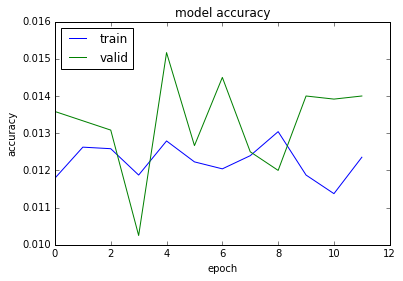

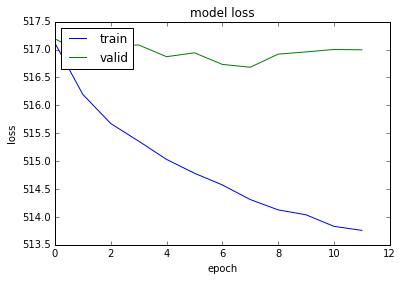

In [22]:
#list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

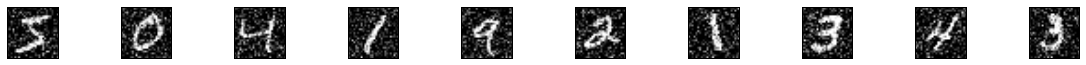

In [23]:
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    #ax = plt.subplot(1, n, i)
    plt.imshow(s_train_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

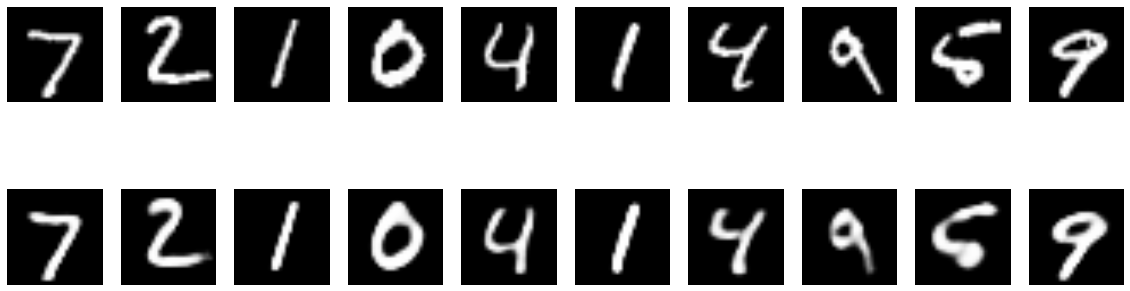

In [24]:

n = 10  # how many digits we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display encoded
    #ax = plt.subplot(2, n, i + 1 + n)
    #plt.imshow(encoded_imgs[i].reshape(6, 6))
    #plt.gray()
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
   
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(test_res_decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [25]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
clf = clf.fit(train_res_encoded_imgs, np.ravel(y_train))

In [26]:
y_pred = clf.predict(test_res_encoded_imgs)

In [27]:
num=len(test_res_encoded_imgs)
r=0
w=0
wrngclassidx=[]
y_test = np.ravel(y_test)
for i in range(num):
        #print ('y_pred ',y_pred[i])
        #print ('labels ',labels[i])
        #without the use of all() returns error truth value of an array with more than one element is ambiguous
        #if y_pred[i].all() == labels[i].all():
        if np.array_equal(y_pred[i],y_test[i]):
            r+=1
        else:
            w+=1
            wrngclassidx.append(i)
print ("tested ",  num, "digits")
print ("correct: ", r, "wrong: ", w, "error rate: ", float(w)*100/(r+w), "%")
print ("got correctly ", float(r)*100/(r+w), "%")
print (len(wrngclassidx))

tested  10000 digits
correct:  9566 wrong:  434 error rate:  4.34 %
got correctly  95.66 %
434


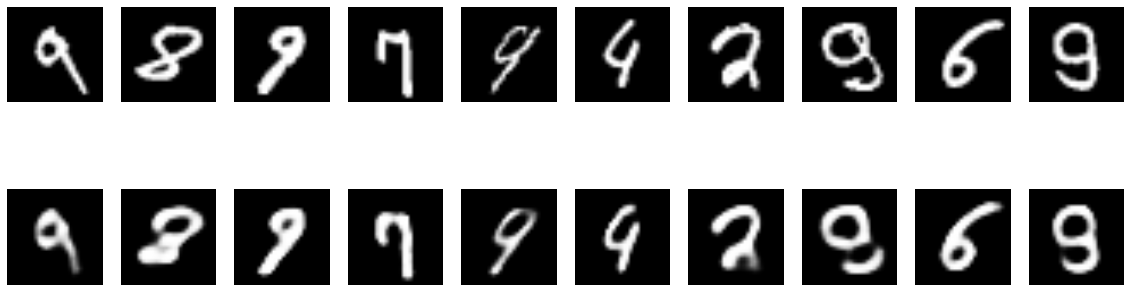

[9, 8, 9, 7, 9, 4, 2, 9, 6, 9]
[4, 3, 7, 9, 4, 9, 8, 8, 5, 8]


In [28]:
n = 10 
actual=[]
predicted=[]
# how many misclassified digits we will display
i=0
plt.figure(figsize=(20, 6))
for idx in wrngclassidx:
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[idx].reshape(28, 28))
        actual.append(y_test[idx])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(test_res_decoded_imgs[idx].reshape(28, 28))
        #print(y_pred[idx])
        predicted.append(y_pred[idx])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        i+=1
        if i==10 :
            break
plt.show()
print (actual)
print (predicted)

In [29]:
y_pred

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [30]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)